# Pronóstico de la energía solar


En esta entrega se realizá una implementación del procedimiento de lectura y limpieza de la base de datos de valores de irradiación solar y otras variables climatológicas para el pronóstico de la energía solar a partir de sistemas fotovoltaicos.

Los datos de irradiación solar y variables climatológicas se obtuvieron del National Renewable Energy Laboratory (NREL), proyecto SolarMap, Loyola Marymount University disponibles en la página web: https://midcdmz.nrel.gov/apps/day.pl?LMU y con el requerimiento de citar para su uso académico: 

Andreas, A., Wilcox, S.; (2012). Solar Resource & Meteorological Assessment Project (SOLRMAP):
Rotating Shadowband Radiometer (RSR); Los Angeles, California (Data); NREL Report No. DA-5500-56502. http://dx.doi.org/10.5439/1052230

# Lectura de los datos

In [53]:
# librerias utlizadas y configuraciones opcionales
import matplotlib.pyplot as plt 
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (13, 8) # Se configura el canvas del matplotlib
#https://www.analyticslane.com/2018/09/19/utilizacion-de-pantallas-retina-en-jupyter-notebook/
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import datetime as dt
import seaborn as sns

In [54]:
# Crea un objeto tipo datetime a partir de los datos 

# PST es la hora, es decir: 846 son las 8:46
# DOY es el número del día en el año. Es decir, 96 sería el 06 de Abirl (31 Enero +28 febrero + 31 marzo + 6 abril)

def create_datetime(row): 
    """
    Procesa los datos para crear una objeto tipo datetime con valores de 
    año, mes, días, hora y minutos

    Parameters
    ----------
    row : fila del dataframe 
        datos de tipo numérico con valores para .

    Returns
    -------
    datetime_real : datetime
        Objecto con los datos de año, mes, días, hora y minutos.
    """
    
    # La hora original está en formato HHMM
    minutes = int(str(int(row.loc['PST']))[-2:])
    try:
        hours = int(str(int(row.loc['PST']))[:-2])
    except:
        hours = 0
    # Timedelta para horas y minutos
    td = dt.timedelta(hours=hours, minutes=minutes)
    
    # Crea un objeto datetime
    datetime_real = (dt.datetime(year=int(row.loc['Year']), month=1, day=1) 
                    + dt.timedelta(days=(int(row.loc['DOY']) - 1))      
                    + td)

    return datetime_real

In [55]:
# Lectura, sin encabezado o indice
path = 'Dataset DNI GHI GNI.csv' 
data = pd.read_csv(path,header=None,encoding='utf-8') 
data.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0,2010,96,846,663.979,928.081,88.9916,18.20,1010.0,-99999.0,...,65.0500,660.314,-99999.0,51.72,110.8,21.66,13.35,44.42,0.0,0.0
1,0,2010,96,847,658.413,919.152,86.4427,18.21,1010.0,-99999.0,...,62.4285,665.227,-99999.0,51.52,111.0,21.72,13.34,44.02,0.0,0.0
2,0,2010,96,848,663.272,923.709,86.0310,18.08,1010.0,-99999.0,...,61.9479,670.182,-99999.0,51.32,111.2,21.82,13.35,44.01,0.0,0.0
3,0,2010,96,849,666.330,924.388,86.2372,18.00,1010.0,-99999.0,...,62.1105,673.325,-99999.0,51.13,111.4,21.88,13.35,43.03,0.0,0.0
4,0,2010,96,850,667.253,921.967,86.2595,18.06,1010.0,-99999.0,...,62.1186,674.574,-99999.0,50.94,111.6,21.86,13.32,44.14,0.0,0.0


In [56]:
# Se elimina la columna 1 de ceros
data.drop(0, inplace=True, axis=1) 
data.head()

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
0,2010,96,846,663.979,928.081,88.9916,18.20,1010.0,-99999.0,-99999.0,...,65.0500,660.314,-99999.0,51.72,110.8,21.66,13.35,44.42,0.0,0.0
1,2010,96,847,658.413,919.152,86.4427,18.21,1010.0,-99999.0,-99999.0,...,62.4285,665.227,-99999.0,51.52,111.0,21.72,13.34,44.02,0.0,0.0
2,2010,96,848,663.272,923.709,86.0310,18.08,1010.0,-99999.0,-99999.0,...,61.9479,670.182,-99999.0,51.32,111.2,21.82,13.35,44.01,0.0,0.0
3,2010,96,849,666.330,924.388,86.2372,18.00,1010.0,-99999.0,-99999.0,...,62.1105,673.325,-99999.0,51.13,111.4,21.88,13.35,43.03,0.0,0.0
4,2010,96,850,667.253,921.967,86.2595,18.06,1010.0,-99999.0,-99999.0,...,62.1186,674.574,-99999.0,50.94,111.6,21.86,13.32,44.14,0.0,0.0


In [57]:
# Nombre de las columnas para facilitar la lectura
new_col = ['Year', 'DOY', 'PST', 'GHI',
            'DNI', 'DHI', 'Air Temp', 'Pressure', 
            'Wind Speed', 'Wind Dir', 'Wind Dir STD',
            'Wind Speed STD', 'Wind Speed Peak', 'Global Uncorrected', 
            'Direct Uncorrected', 'Diffuse Uncorrected', 'Global Secondary',
            'Unnamed: 18', 'Zenith', 'Azimuth', 'CR1000 Temp',
            'Battery', 'Humidity', 'Precipitation', 'Precipitation Acc']
data.columns = new_col
data.head()

,Year,DOY,PST,GHI,DNI,DHI,Air Temp,Pressure,Wind Speed,Wind Dir,...,Diffuse Uncorrected,Global Secondary,Unnamed: 18,Zenith,Azimuth,CR1000 Temp,Battery,Humidity,Precipitation,Precipitation Acc
0,2010,96,846,663.979,928.081,88.9916,18.20,1010.0,-99999.0,-99999.0,...,65.0500,660.314,-99999.0,51.72,110.8,21.66,13.35,44.42,0.0,0.0
1,2010,96,847,658.413,919.152,86.4427,18.21,1010.0,-99999.0,-99999.0,...,62.4285,665.227,-99999.0,51.52,111.0,21.72,13.34,44.02,0.0,0.0
2,2010,96,848,663.272,923.709,86.0310,18.08,1010.0,-99999.0,-99999.0,...,61.9479,670.182,-99999.0,51.32,111.2,21.82,13.35,44.01,0.0,0.0
3,2010,96,849,666.330,924.388,86.2372,18.00,1010.0,-99999.0,-99999.0,...,62.1105,673.325,-99999.0,51.13,111.4,21.88,13.35,43.03,0.0,0.0
4,2010,96,850,667.253,921.967,86.2595,18.06,1010.0,-99999.0,-99999.0,...,62.1186,674.574,-99999.0,50.94,111.6,21.86,13.32,44.14,0.0,0.0


## Características o columnas innecesarias

In [58]:
# Se eliminan las columnas que no se usarán por el momento
# 'Precipitation Acc', 'Precipitation',
data.drop(['Global Secondary', 'Unnamed: 18', 'CR1000 Temp', 'Battery',
           'Global Uncorrected', 'Direct Uncorrected', 'Diffuse Uncorrected',
           'Wind Speed', 'Wind Dir', 'Wind Dir STD',
           'Wind Speed STD', 'Wind Speed Peak'], axis=1, inplace=True)
data.head()

,Year,DOY,PST,GHI,DNI,DHI,Air Temp,Pressure,Zenith,Azimuth,Humidity,Precipitation,Precipitation Acc
0,2010,96,846,663.979,928.081,88.9916,18.20,1010.0,51.72,110.8,44.42,0.0,0.0
1,2010,96,847,658.413,919.152,86.4427,18.21,1010.0,51.52,111.0,44.02,0.0,0.0
2,2010,96,848,663.272,923.709,86.0310,18.08,1010.0,51.32,111.2,44.01,0.0,0.0
3,2010,96,849,666.330,924.388,86.2372,18.00,1010.0,51.13,111.4,43.03,0.0,0.0
4,2010,96,850,667.253,921.967,86.2595,18.06,1010.0,50.94,111.6,44.14,0.0,0.0


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Year               1048576 non-null  int64  
 1   DOY                1048576 non-null  int64  
 2   PST                1048576 non-null  int64  
 3   GHI                1048576 non-null  float64
 4   DNI                1048576 non-null  float64
 5   DHI                1048576 non-null  float64
 6   Air Temp           1048576 non-null  float64
 7   Pressure           1048576 non-null  float64
 8   Zenith             1048576 non-null  float64
 9   Azimuth            1048576 non-null  float64
 10  Humidity           1048576 non-null  float64
 11  Precipitation      1048576 non-null  float64
 12  Precipitation Acc  1048576 non-null  float64
dtypes: float64(10), int64(3)
memory usage: 104.0 MB


## Creación del índice, datetime 

In [60]:
# para pruebas
#row = data.loc[0]
#create_datetime(row)

data['datetime'] = data.apply(create_datetime, axis=1)
data.set_index('datetime', inplace=True)
data.head()

,Year,DOY,PST,GHI,DNI,DHI,Air Temp,Pressure,Zenith,Azimuth,Humidity,Precipitation,Precipitation Acc
datetime,,,,,,,,,,,,,
2010-04-06 08:46:00,2010,96,846,663.979,928.081,88.9916,18.20,1010.0,51.72,110.8,44.42,0.0,0.0
2010-04-06 08:47:00,2010,96,847,658.413,919.152,86.4427,18.21,1010.0,51.52,111.0,44.02,0.0,0.0
2010-04-06 08:48:00,2010,96,848,663.272,923.709,86.0310,18.08,1010.0,51.32,111.2,44.01,0.0,0.0
2010-04-06 08:49:00,2010,96,849,666.330,924.388,86.2372,18.00,1010.0,51.13,111.4,43.03,0.0,0.0
2010-04-06 08:50:00,2010,96,850,667.253,921.967,86.2595,18.06,1010.0,50.94,111.6,44.14,0.0,0.0


In [61]:
# Columna con la 'Hora' 
data["Hour"] = data.index.hour

# Valores negativos

Los datos contienen algunos valores negativos. Para este tipo de datos, solo son aplicables los valores positivos.

In [62]:
# Imprime la columna, el número de valores negativos y su respectivo % de datos negativos.
for x in data.columns:
    print(x, "N°. Negativos:",len(data[data[x] < 0]), "Porcentaje:",round((len(data[data[x] < 0])/len(data)), 4))

Year N°. Negativos: 0 Porcentaje: 0.0
DOY N°. Negativos: 0 Porcentaje: 0.0
PST N°. Negativos: 0 Porcentaje: 0.0
GHI N°. Negativos: 2 Porcentaje: 0.0
DNI N°. Negativos: 2 Porcentaje: 0.0
DHI N°. Negativos: 78 Porcentaje: 0.0001
Air Temp N°. Negativos: 0 Porcentaje: 0.0
Pressure N°. Negativos: 0 Porcentaje: 0.0
Zenith N°. Negativos: 0 Porcentaje: 0.0
Azimuth N°. Negativos: 0 Porcentaje: 0.0
Humidity N°. Negativos: 0 Porcentaje: 0.0
Precipitation N°. Negativos: 0 Porcentaje: 0.0
Precipitation Acc N°. Negativos: 0 Porcentaje: 0.0
Hour N°. Negativos: 0 Porcentaje: 0.0


In [63]:
len(data)

1048576

## Reducción de un minuto a quince minutos en la frecuencia de los datos 

In [64]:
# Esto se usa, para volver todos los valores del dataset a una resolución de 15 minutos
# ya que están en resolución de 1 min
data_re = data.resample("15T").max()
#data_re = data.resample("15T").mean()
#data_re = data_re.astype({'Year': int, 'DOY': int, 'PST': int })
print(data_re.dtypes)
data_re = data_re.dropna()
data_re.head()    

Year                   int64
DOY                    int64
PST                    int64
GHI                  float64
DNI                  float64
DHI                  float64
Air Temp             float64
Pressure             float64
Zenith               float64
Azimuth              float64
Humidity             float64
Precipitation        float64
Precipitation Acc    float64
Hour                   int64
dtype: object


,Year,DOY,PST,GHI,DNI,DHI,Air Temp,Pressure,Zenith,Azimuth,Humidity,Precipitation,Precipitation Acc,Hour
datetime,,,,,,,,,,,,,,
2010-04-06 08:45:00,2010,96,859,692.934,928.081,89.4133,19.01,1010.0,51.72,113.5,44.42,0.0,0.0,8
2010-04-06 09:00:00,2010,96,914,743.371,953.324,89.4520,20.25,1010.0,49.02,116.7,42.76,0.0,0.0,9
2010-04-06 09:15:00,2010,96,929,780.811,962.532,88.8216,20.40,1010.0,46.21,120.3,39.72,0.0,0.0,9
2010-04-06 09:30:00,2010,96,944,819.969,968.244,90.8170,21.40,1010.0,43.48,124.2,40.27,0.0,0.0,9
2010-04-06 09:45:00,2010,96,959,852.693,978.547,92.2588,21.09,1010.0,40.86,128.5,37.88,0.0,0.0,9


In [65]:
len(data_re)

69906

In [66]:
#corrección del dato PST: hora original está en formato HHMM
# debido al resample, se corrige para que quede al comienzo del intervalo de tiempo
data_re['PST'] = data_re['PST'] - 14 
data_re.head()

,Year,DOY,PST,GHI,DNI,DHI,Air Temp,Pressure,Zenith,Azimuth,Humidity,Precipitation,Precipitation Acc,Hour
datetime,,,,,,,,,,,,,,
2010-04-06 08:45:00,2010,96,845,692.934,928.081,89.4133,19.01,1010.0,51.72,113.5,44.42,0.0,0.0,8
2010-04-06 09:00:00,2010,96,900,743.371,953.324,89.4520,20.25,1010.0,49.02,116.7,42.76,0.0,0.0,9
2010-04-06 09:15:00,2010,96,915,780.811,962.532,88.8216,20.40,1010.0,46.21,120.3,39.72,0.0,0.0,9
2010-04-06 09:30:00,2010,96,930,819.969,968.244,90.8170,21.40,1010.0,43.48,124.2,40.27,0.0,0.0,9
2010-04-06 09:45:00,2010,96,945,852.693,978.547,92.2588,21.09,1010.0,40.86,128.5,37.88,0.0,0.0,9


In [67]:
# Se muestra la suma de los valores negativos y se establecen los valores 
# negativos en 0, y se muestra la suma de los valores negativos.
print(data_re[data_re < 0].sum())
data_re[data_re < 0] = 0
data_re.head()

Year                 0.00000
DOY                  0.00000
PST                  0.00000
GHI                  0.00000
DNI                  0.00000
DHI                 -0.60751
Air Temp             0.00000
Pressure             0.00000
Zenith               0.00000
Azimuth              0.00000
Humidity             0.00000
Precipitation        0.00000
Precipitation Acc    0.00000
Hour                 0.00000
dtype: float64


,Year,DOY,PST,GHI,DNI,DHI,Air Temp,Pressure,Zenith,Azimuth,Humidity,Precipitation,Precipitation Acc,Hour
datetime,,,,,,,,,,,,,,
2010-04-06 08:45:00,2010,96,845,692.934,928.081,89.4133,19.01,1010.0,51.72,113.5,44.42,0.0,0.0,8
2010-04-06 09:00:00,2010,96,900,743.371,953.324,89.4520,20.25,1010.0,49.02,116.7,42.76,0.0,0.0,9
2010-04-06 09:15:00,2010,96,915,780.811,962.532,88.8216,20.40,1010.0,46.21,120.3,39.72,0.0,0.0,9
2010-04-06 09:30:00,2010,96,930,819.969,968.244,90.8170,21.40,1010.0,43.48,124.2,40.27,0.0,0.0,9
2010-04-06 09:45:00,2010,96,945,852.693,978.547,92.2588,21.09,1010.0,40.86,128.5,37.88,0.0,0.0,9


In [68]:
# Verifique los datos nulos.
print(data_re[data_re < 0].sum()) # Se verifica que no hay valores negativos
# Todos los valores en cero se eliminan.
#data_re = data_re.drop(data_re[data_re['GHI']<1].index,axis=0)
#data_re = data_re.drop(data_re[data_re['DHI']<1].index,axis=0)
#data_re = data_re.drop(data_re[data_re['DNI']<1].index,axis=0)

Year                 0.0
DOY                  0.0
PST                  0.0
GHI                  0.0
DNI                  0.0
DHI                  0.0
Air Temp             0.0
Pressure             0.0
Zenith               0.0
Azimuth              0.0
Humidity             0.0
Precipitation        0.0
Precipitation Acc    0.0
Hour                 0.0
dtype: float64


## Resumen estadistico del dataset

In [69]:
round(data_re.describe(), 4).T 

,count,mean,std,min,25%,50%,75%,max
Year,69906.0,2010.7582,0.6635,2010.000,2010.0000,2011.0000,2011.0000,2012.000
DOY,69906.0,183.2192,105.4061,1.000,92.0000,183.0000,274.0000,365.000
PST,69906.0,1172.4741,692.3426,0.000,600.0000,1145.0000,1745.0000,2345.000
GHI,69906.0,238.3890,331.6654,0.000,0.0000,5.9816,463.4028,1494.380
DNI,69906.0,261.9293,372.7327,0.000,0.0000,0.0000,669.6400,1557.030
DHI,69906.0,83.7706,137.1371,0.000,0.0000,5.9739,109.0878,915.325
Air Temp,69906.0,16.3991,3.9635,4.189,13.7800,16.4000,18.8400,38.500
Pressure,69906.0,1001.0652,67.5829,388.300,1010.0000,1010.0000,1010.0000,1021.000
Zenith,69906.0,90.7798,39.0908,10.780,58.5700,90.8000,122.6000,169.500
Azimuth,69906.0,183.3839,99.7982,4.011,91.7000,186.4500,272.2000,359.800


## Datos de un día

In [70]:
# Dado que la irradianza es cero en la noche, solo aparecen datos a partir del amanecer
# y hasta el atardecer 
data_re[61:(61+4*24)] 

,Year,DOY,PST,GHI,DNI,DHI,Air Temp,Pressure,Zenith,Azimuth,Humidity,Precipitation,Precipitation Acc,Hour
datetime,,,,,,,,,,,,,,
2010-04-07 00:00:00,2010,97,0,0.046366,0.0,0.046366,12.79,1010.0,139.2,6.685,72.79,0.0,0.0,0
2010-04-07 00:15:00,2010,97,15,0.046366,0.0,0.046366,13.07,1010.0,139.0,12.280,69.99,0.0,0.0,0
2010-04-07 00:30:00,2010,97,30,0.092732,0.0,0.092732,13.54,1010.0,138.4,17.720,61.42,0.0,0.0,0
2010-04-07 00:45:00,2010,97,45,0.046366,0.0,0.046366,13.64,1010.0,137.6,22.950,60.26,0.0,0.0,0
2010-04-07 01:00:00,2010,97,100,0.092732,0.0,0.092732,13.65,1010.0,136.5,27.950,50.71,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-04-07 22:45:00,2010,97,2245,0.046355,0.0,0.046355,15.11,1010.0,136.7,339.100,66.60,0.0,0.0,22
2010-04-07 23:00:00,2010,97,2300,0.000000,0.0,0.000000,15.59,1010.0,137.6,344.400,58.74,0.0,0.0,23
2010-04-07 23:15:00,2010,97,2315,0.046354,0.0,0.046354,15.51,1010.0,138.3,349.900,56.96,0.0,0.0,23


## Número de datos en el dataset, después de realizar la limpieza

In [71]:
len(data_re)

69906

## Graficas de caracteristicas y sus relaciones/dependencias
1. Principales métricas: Irradiancia Global horizontal (GHI), Irradiancia Normal Directa (DNI),  Irradiancia Difusa Horizontal (DHI)
2. Correlaciones
3. Correlación de GHI / DNI / DHI específicamente
4. Promedio de GHI / DNI / DHI durante el año
5. Promedio de GHI / DNI / DHI a lo largo del día
6. Promedio de GHI / DNI / DHI por temperatura del aire

In [72]:
# Se elimina esta columna para hacer la correlación
data_re.drop(['Year','Hour'], axis=1, inplace=True)

In [73]:
# Último valor del dataset, para ver la fecha 
#data.iloc[-1] 

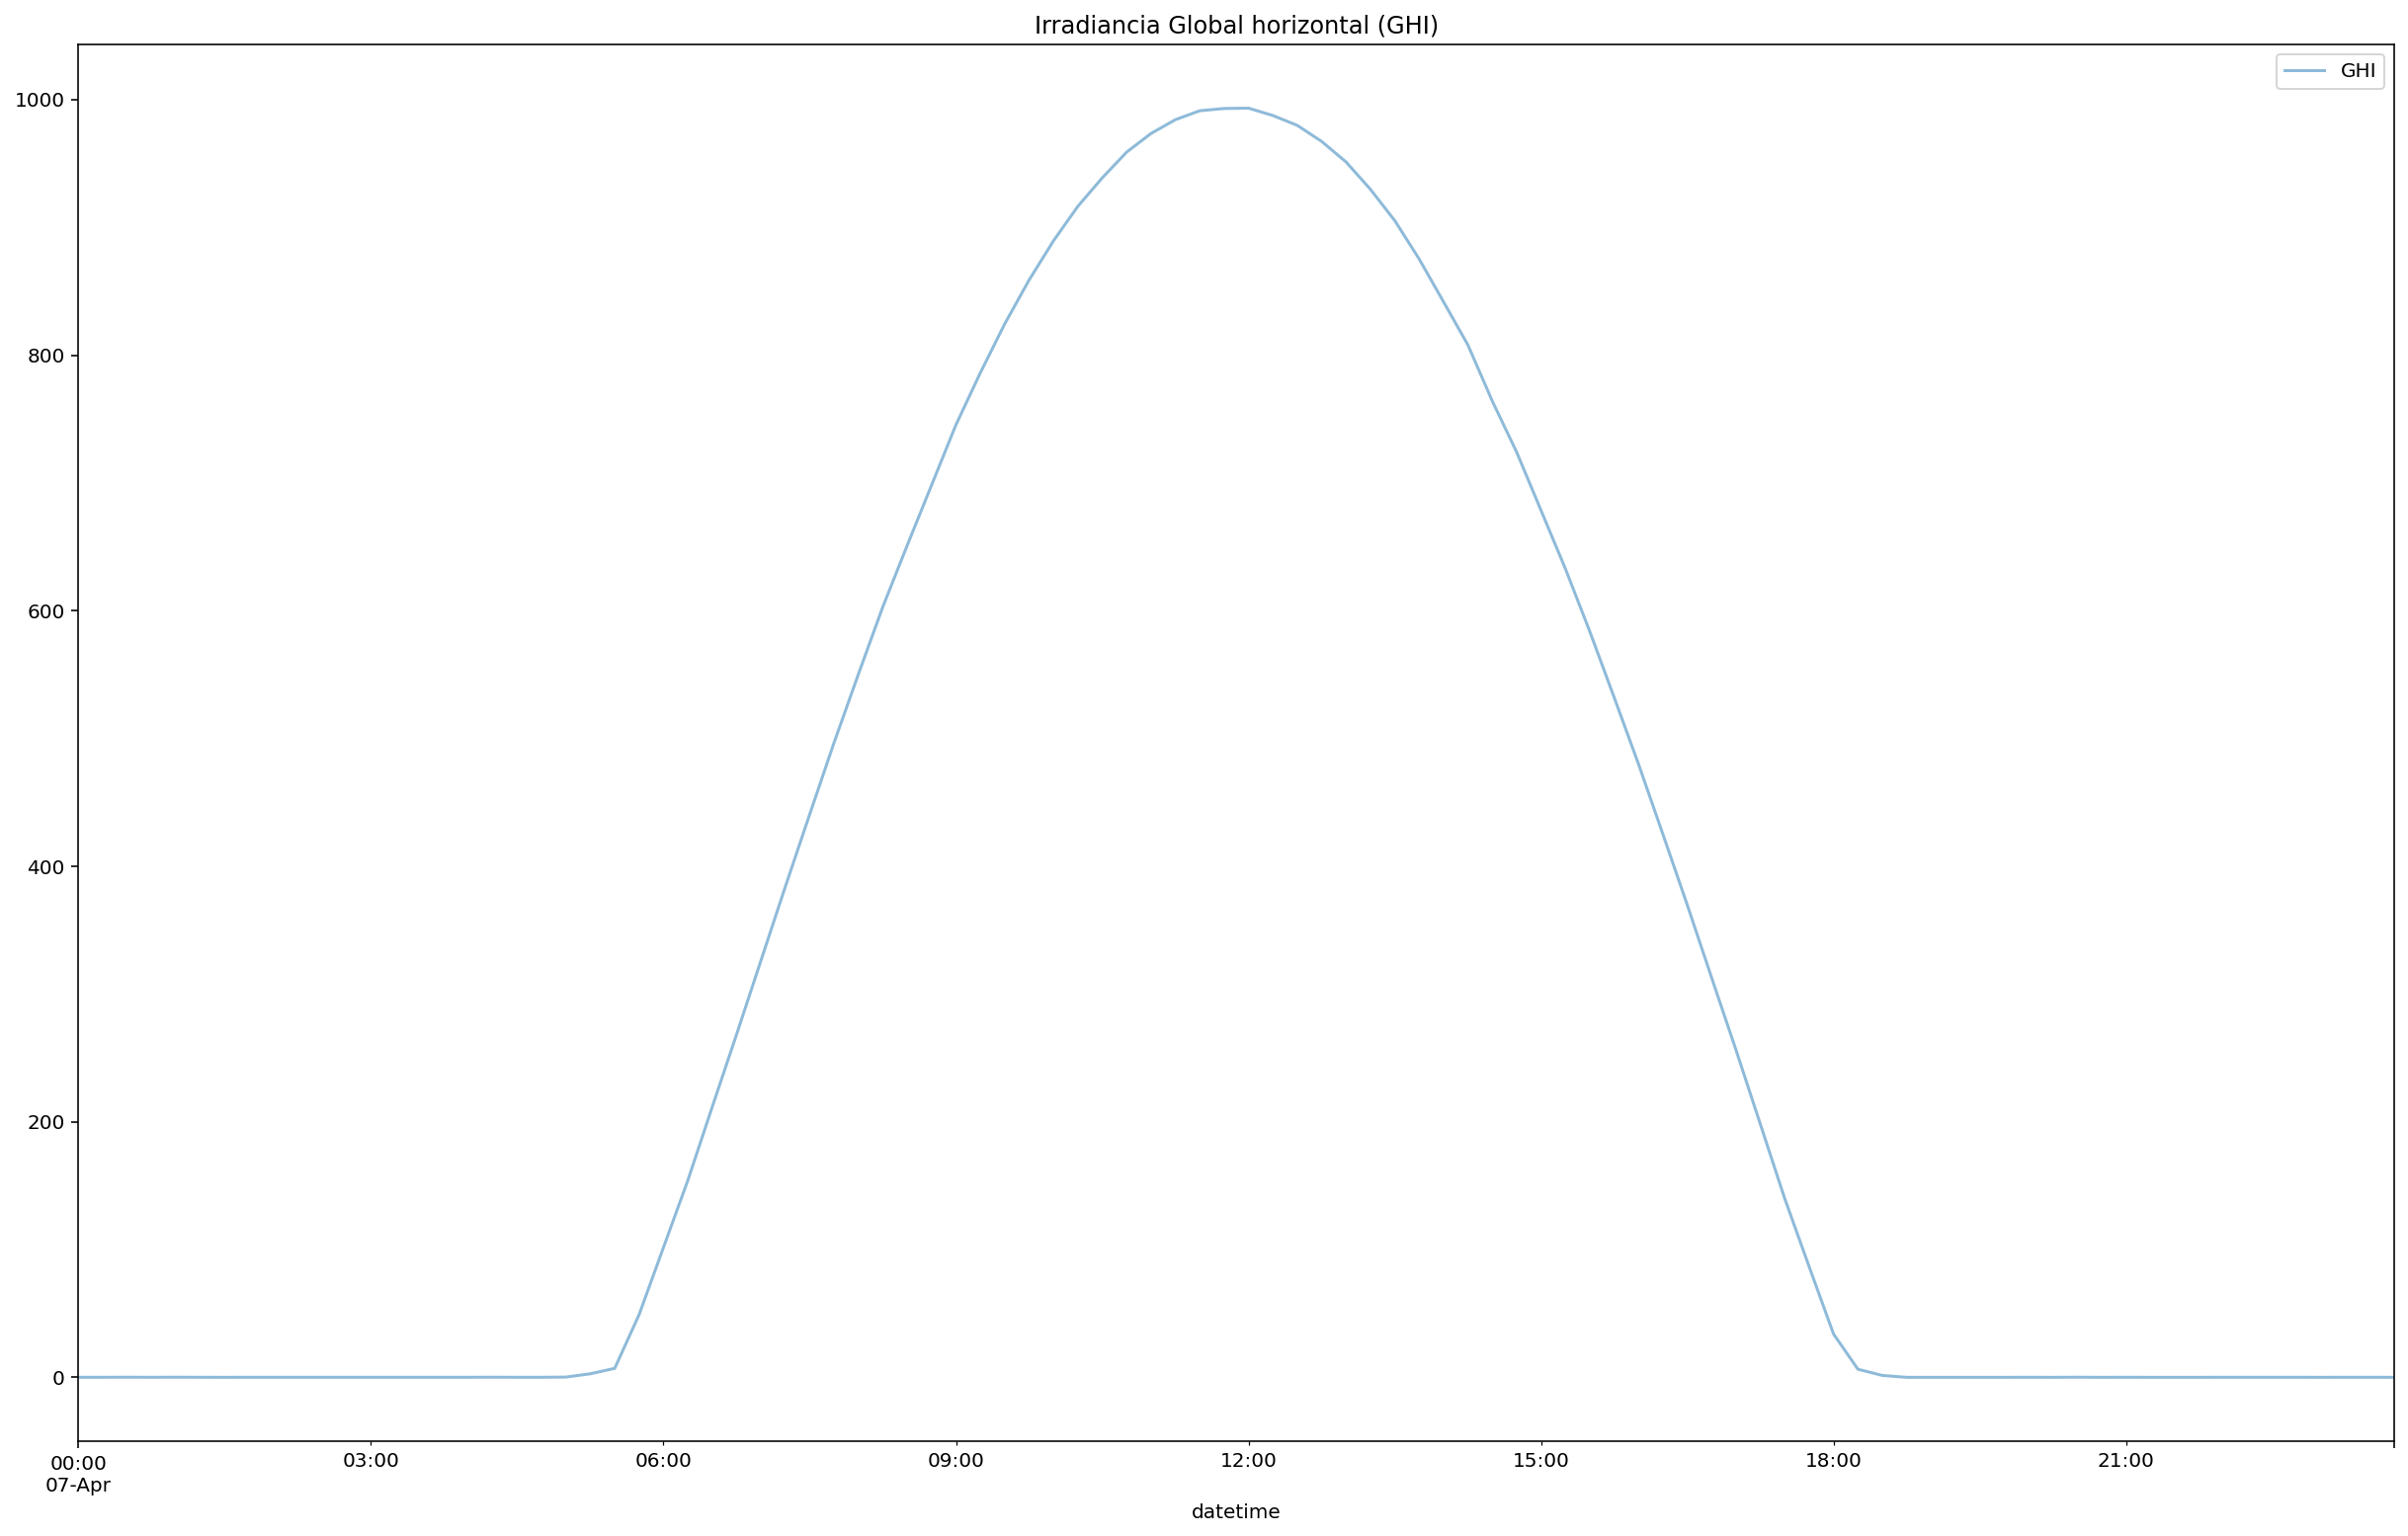

In [74]:
# Gráfica de irradiancia a lo largo del tiempo
data_re[['GHI']][61:(61+4*24)].plot(alpha=.5,figsize=(21, 13))
plt.title('Irradiancia Global horizontal (GHI)');

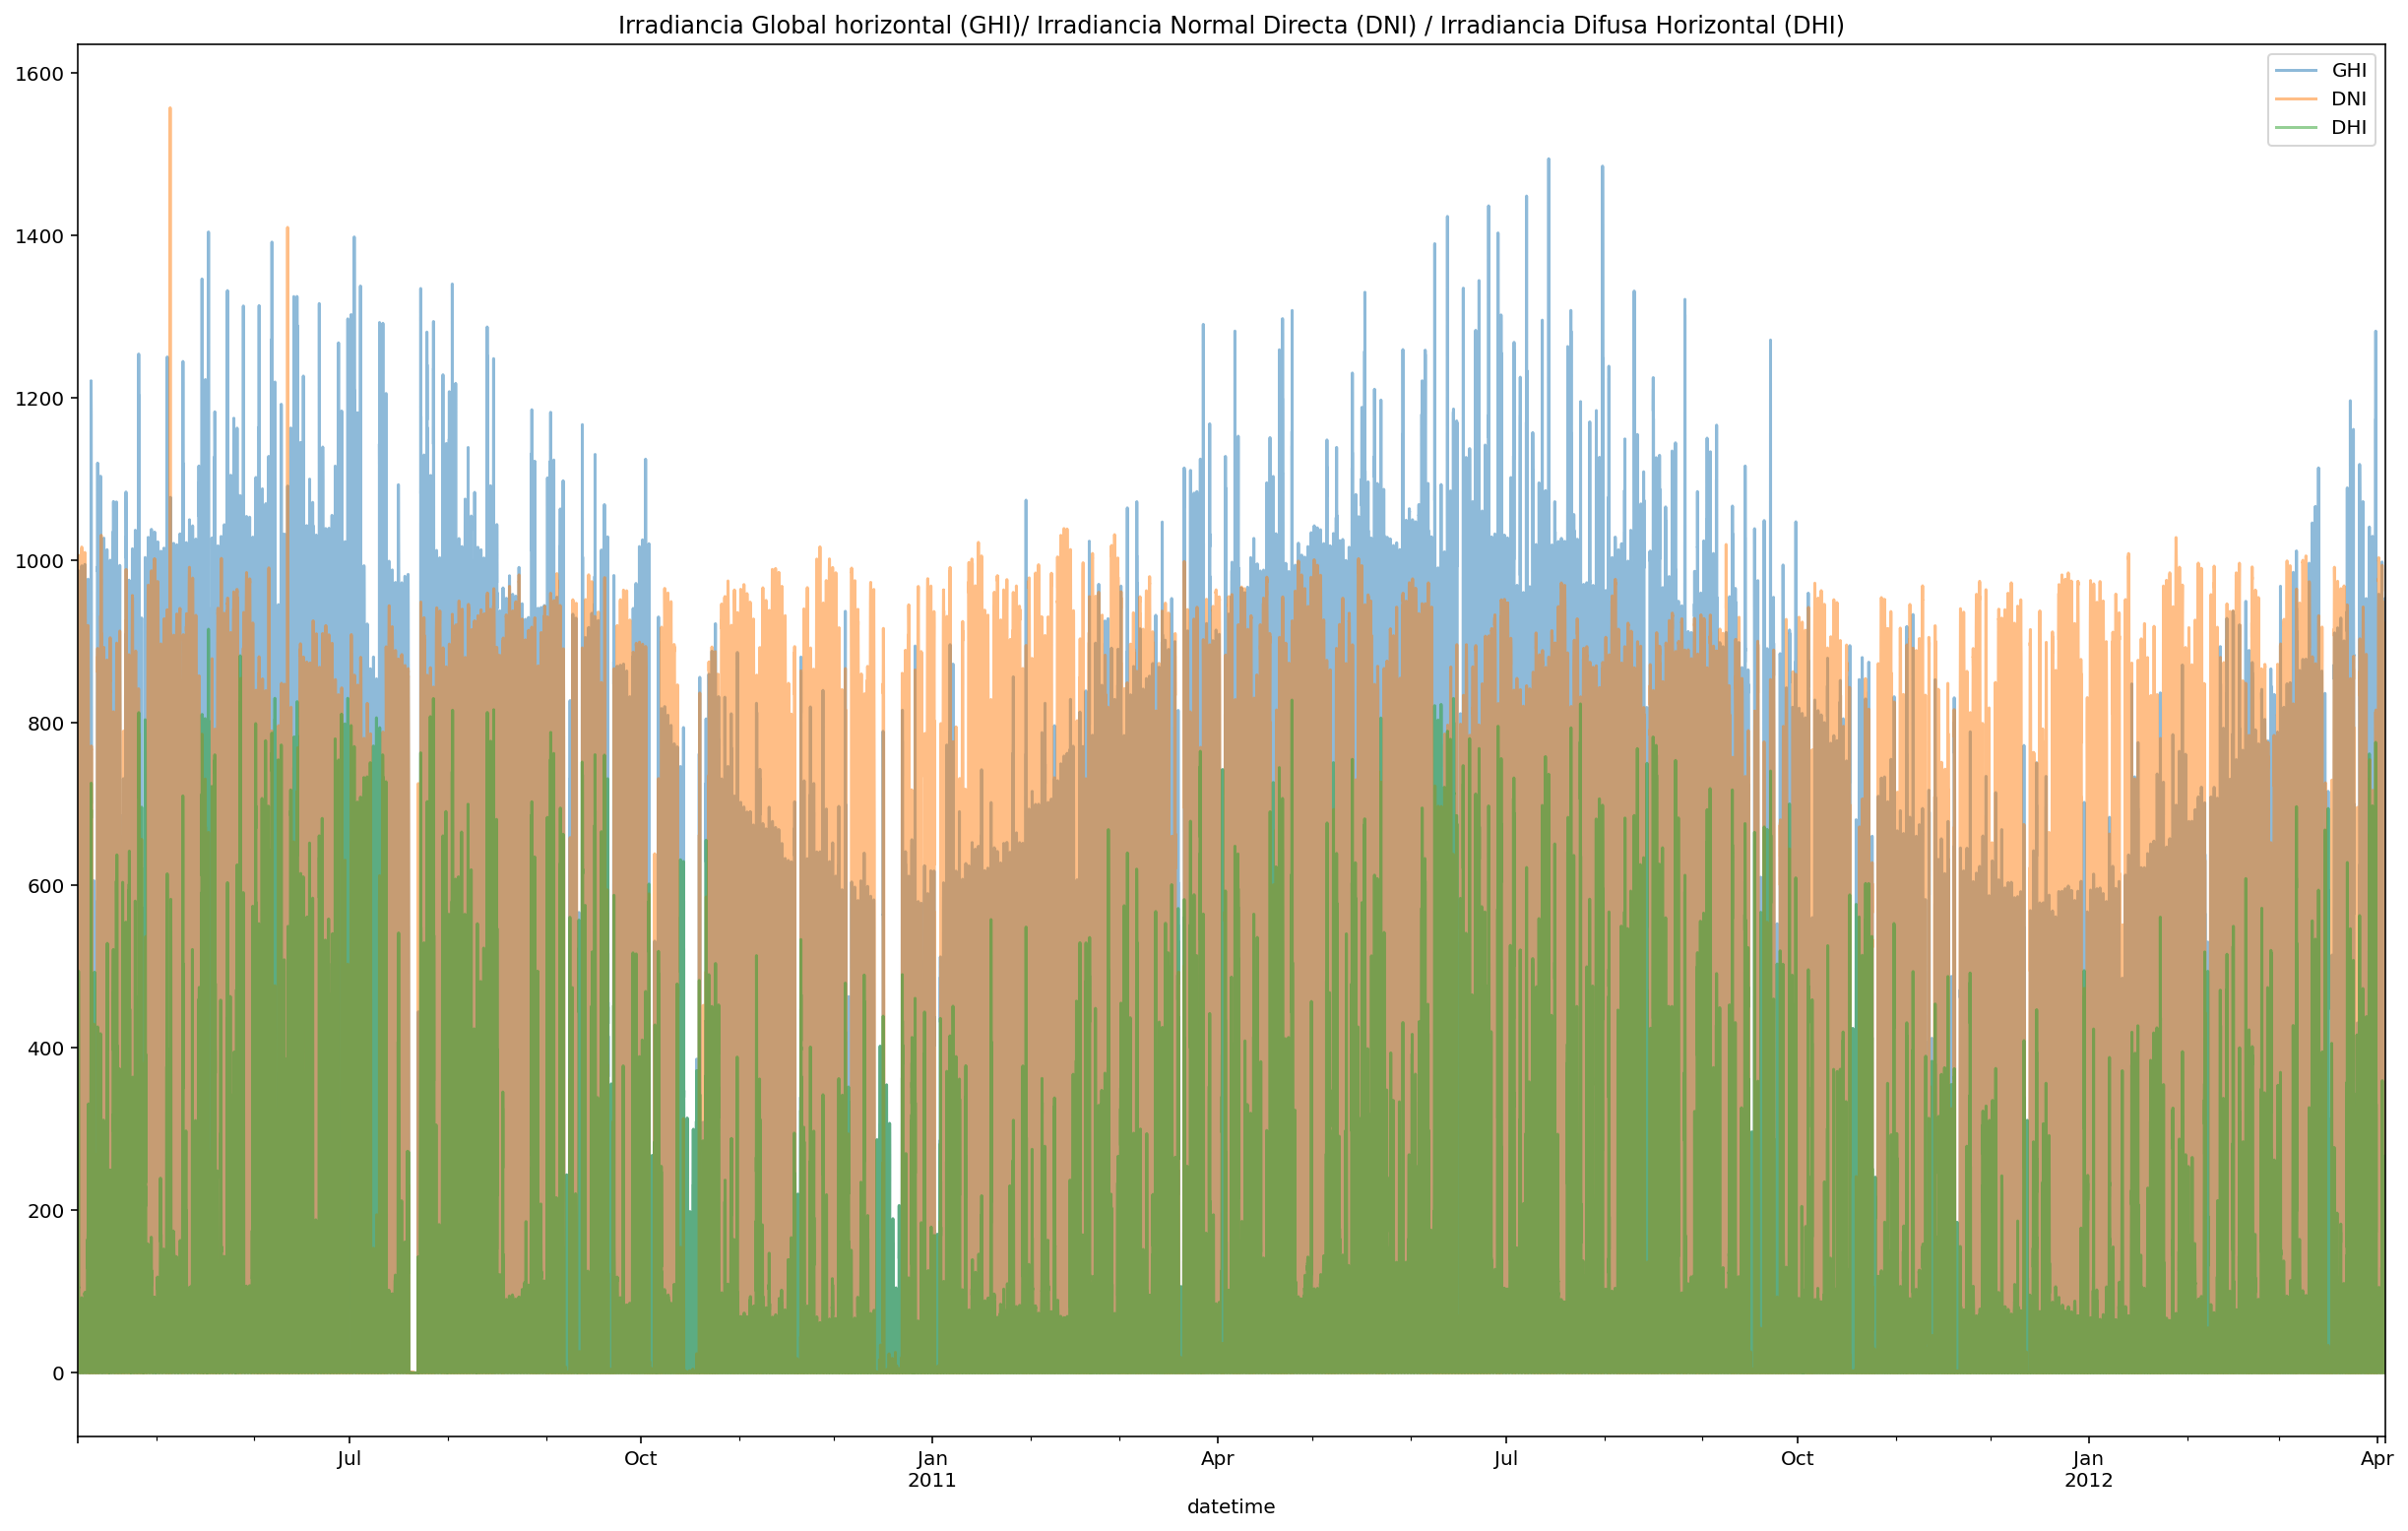

In [75]:
# Grafica de irradiancia a lo largo del tiempo
data_re[['GHI', 'DNI', 'DHI']].plot(alpha=.5,figsize=(21, 13))
plt.title('Irradiancia Global horizontal (GHI)/ Irradiancia Normal Directa (DNI) / Irradiancia Difusa Horizontal (DHI)');

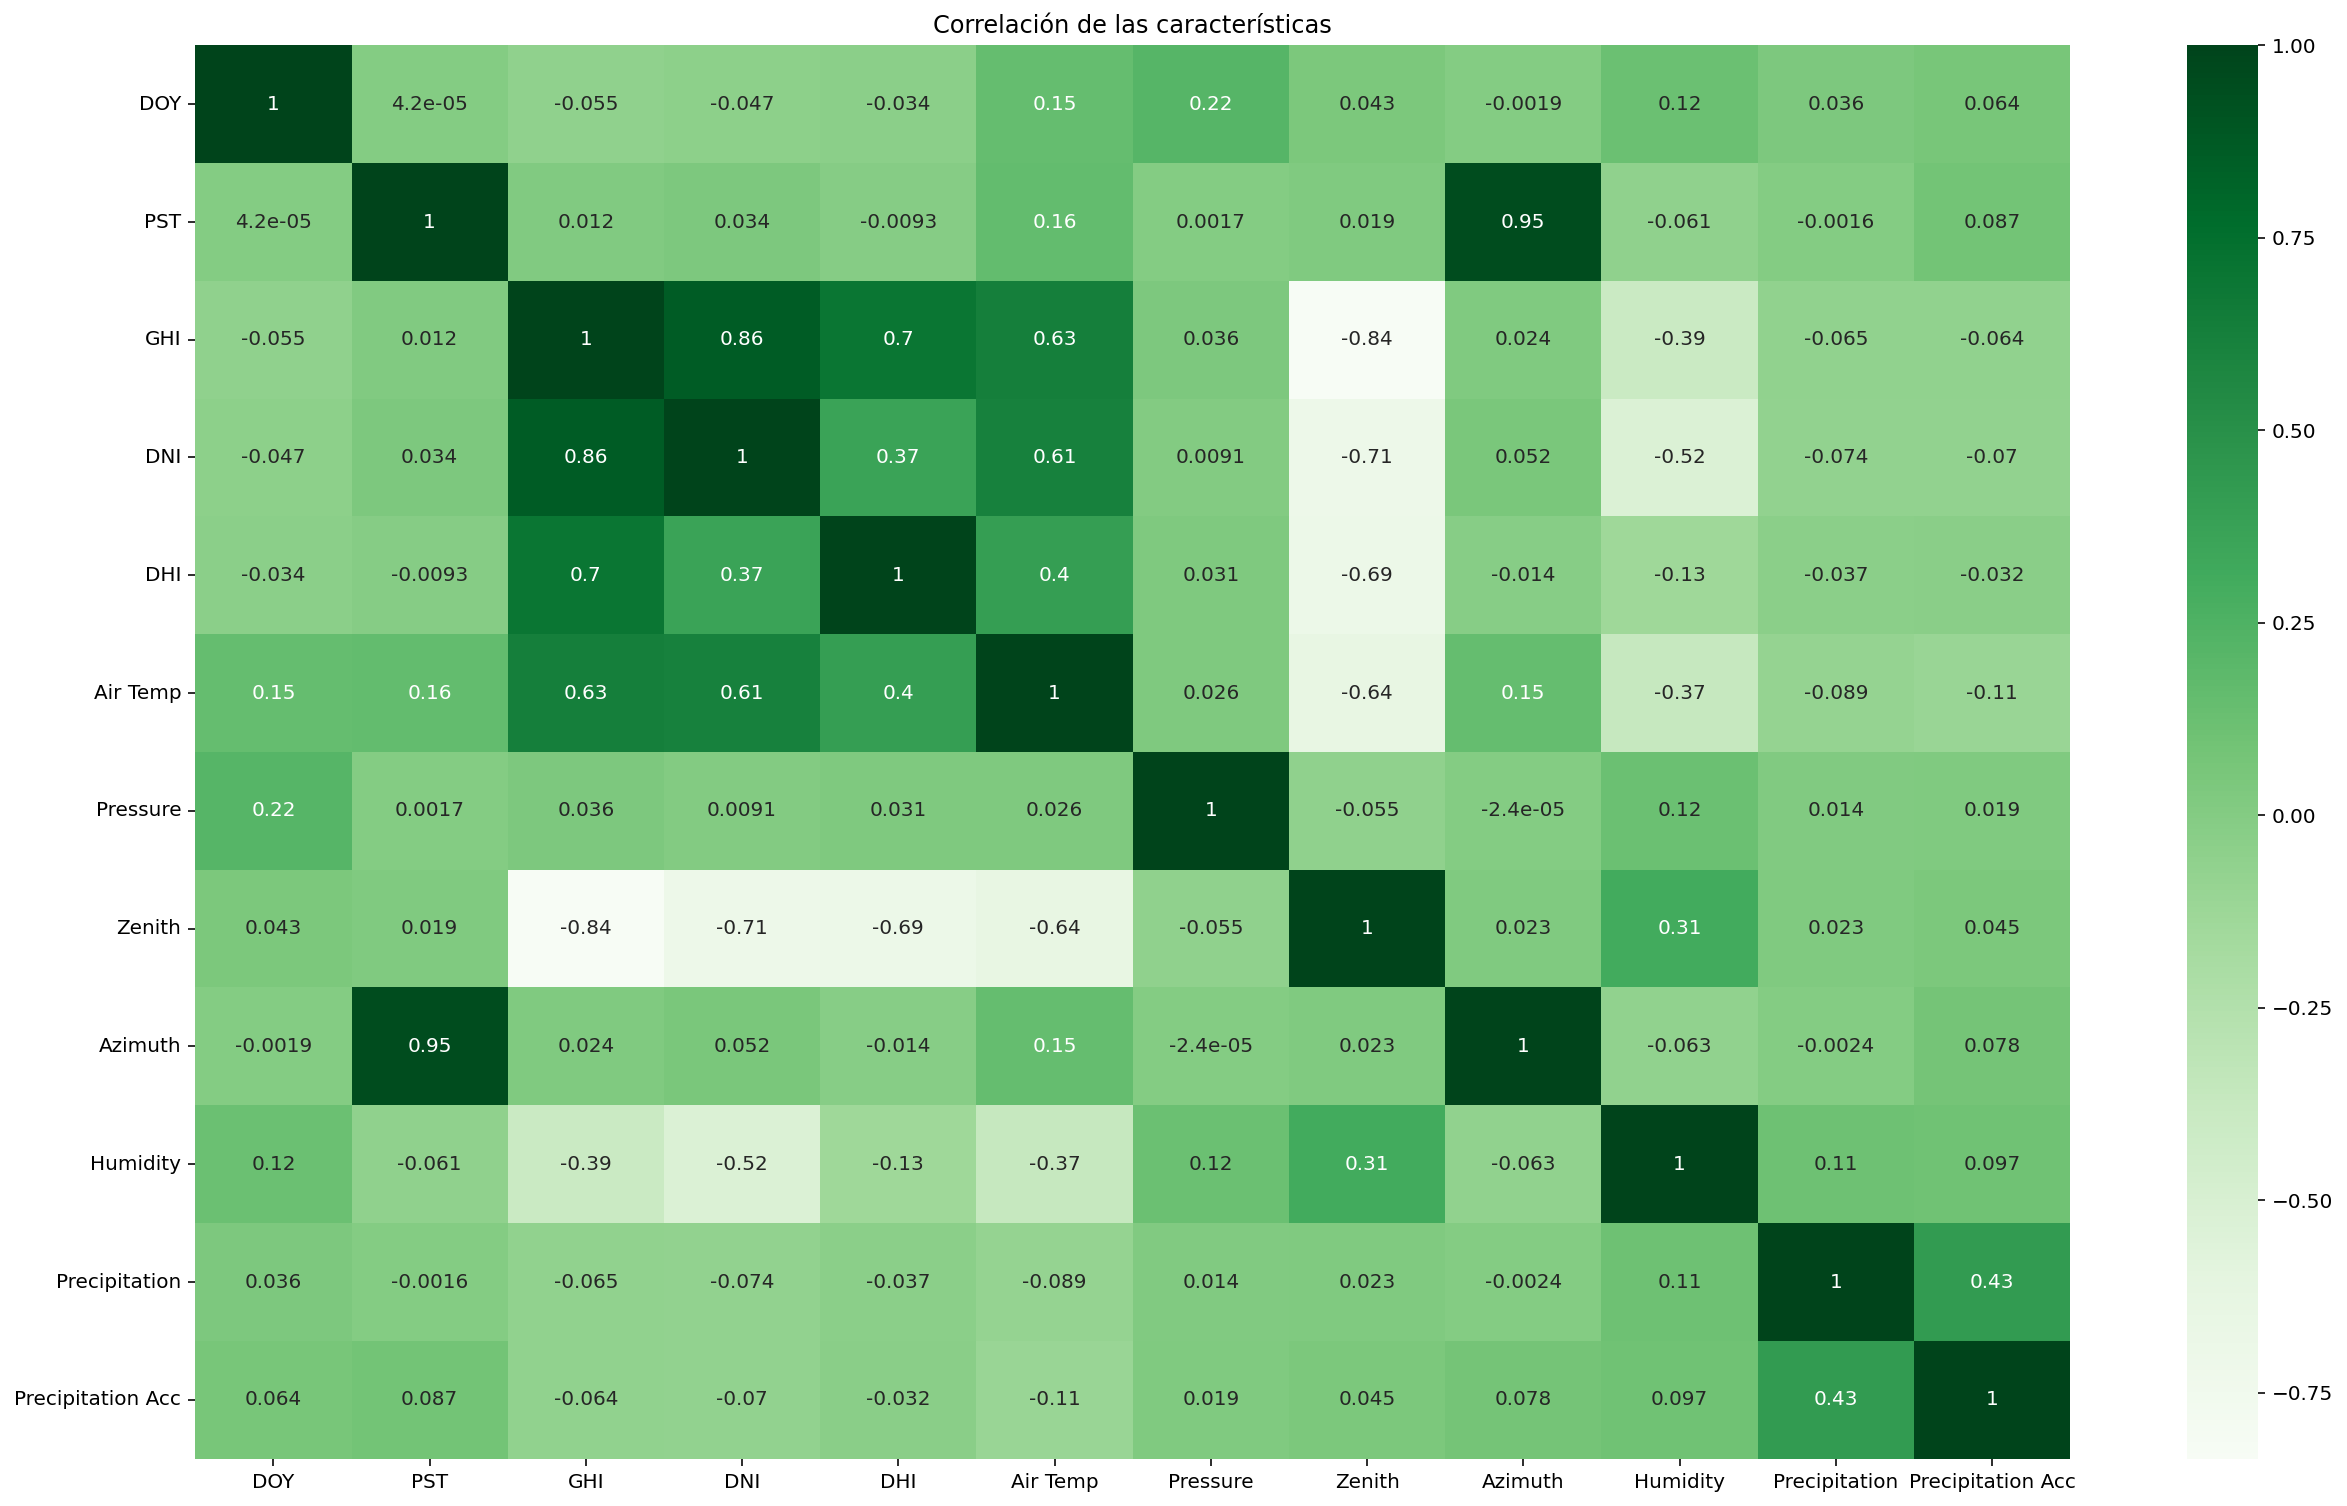

In [76]:
# Correlacion para todas las variables
plt.figure(figsize=(21, 13))
sns.heatmap(data_re.corr(), cmap='Greens', annot=True)
plt.title('Correlación de las características');

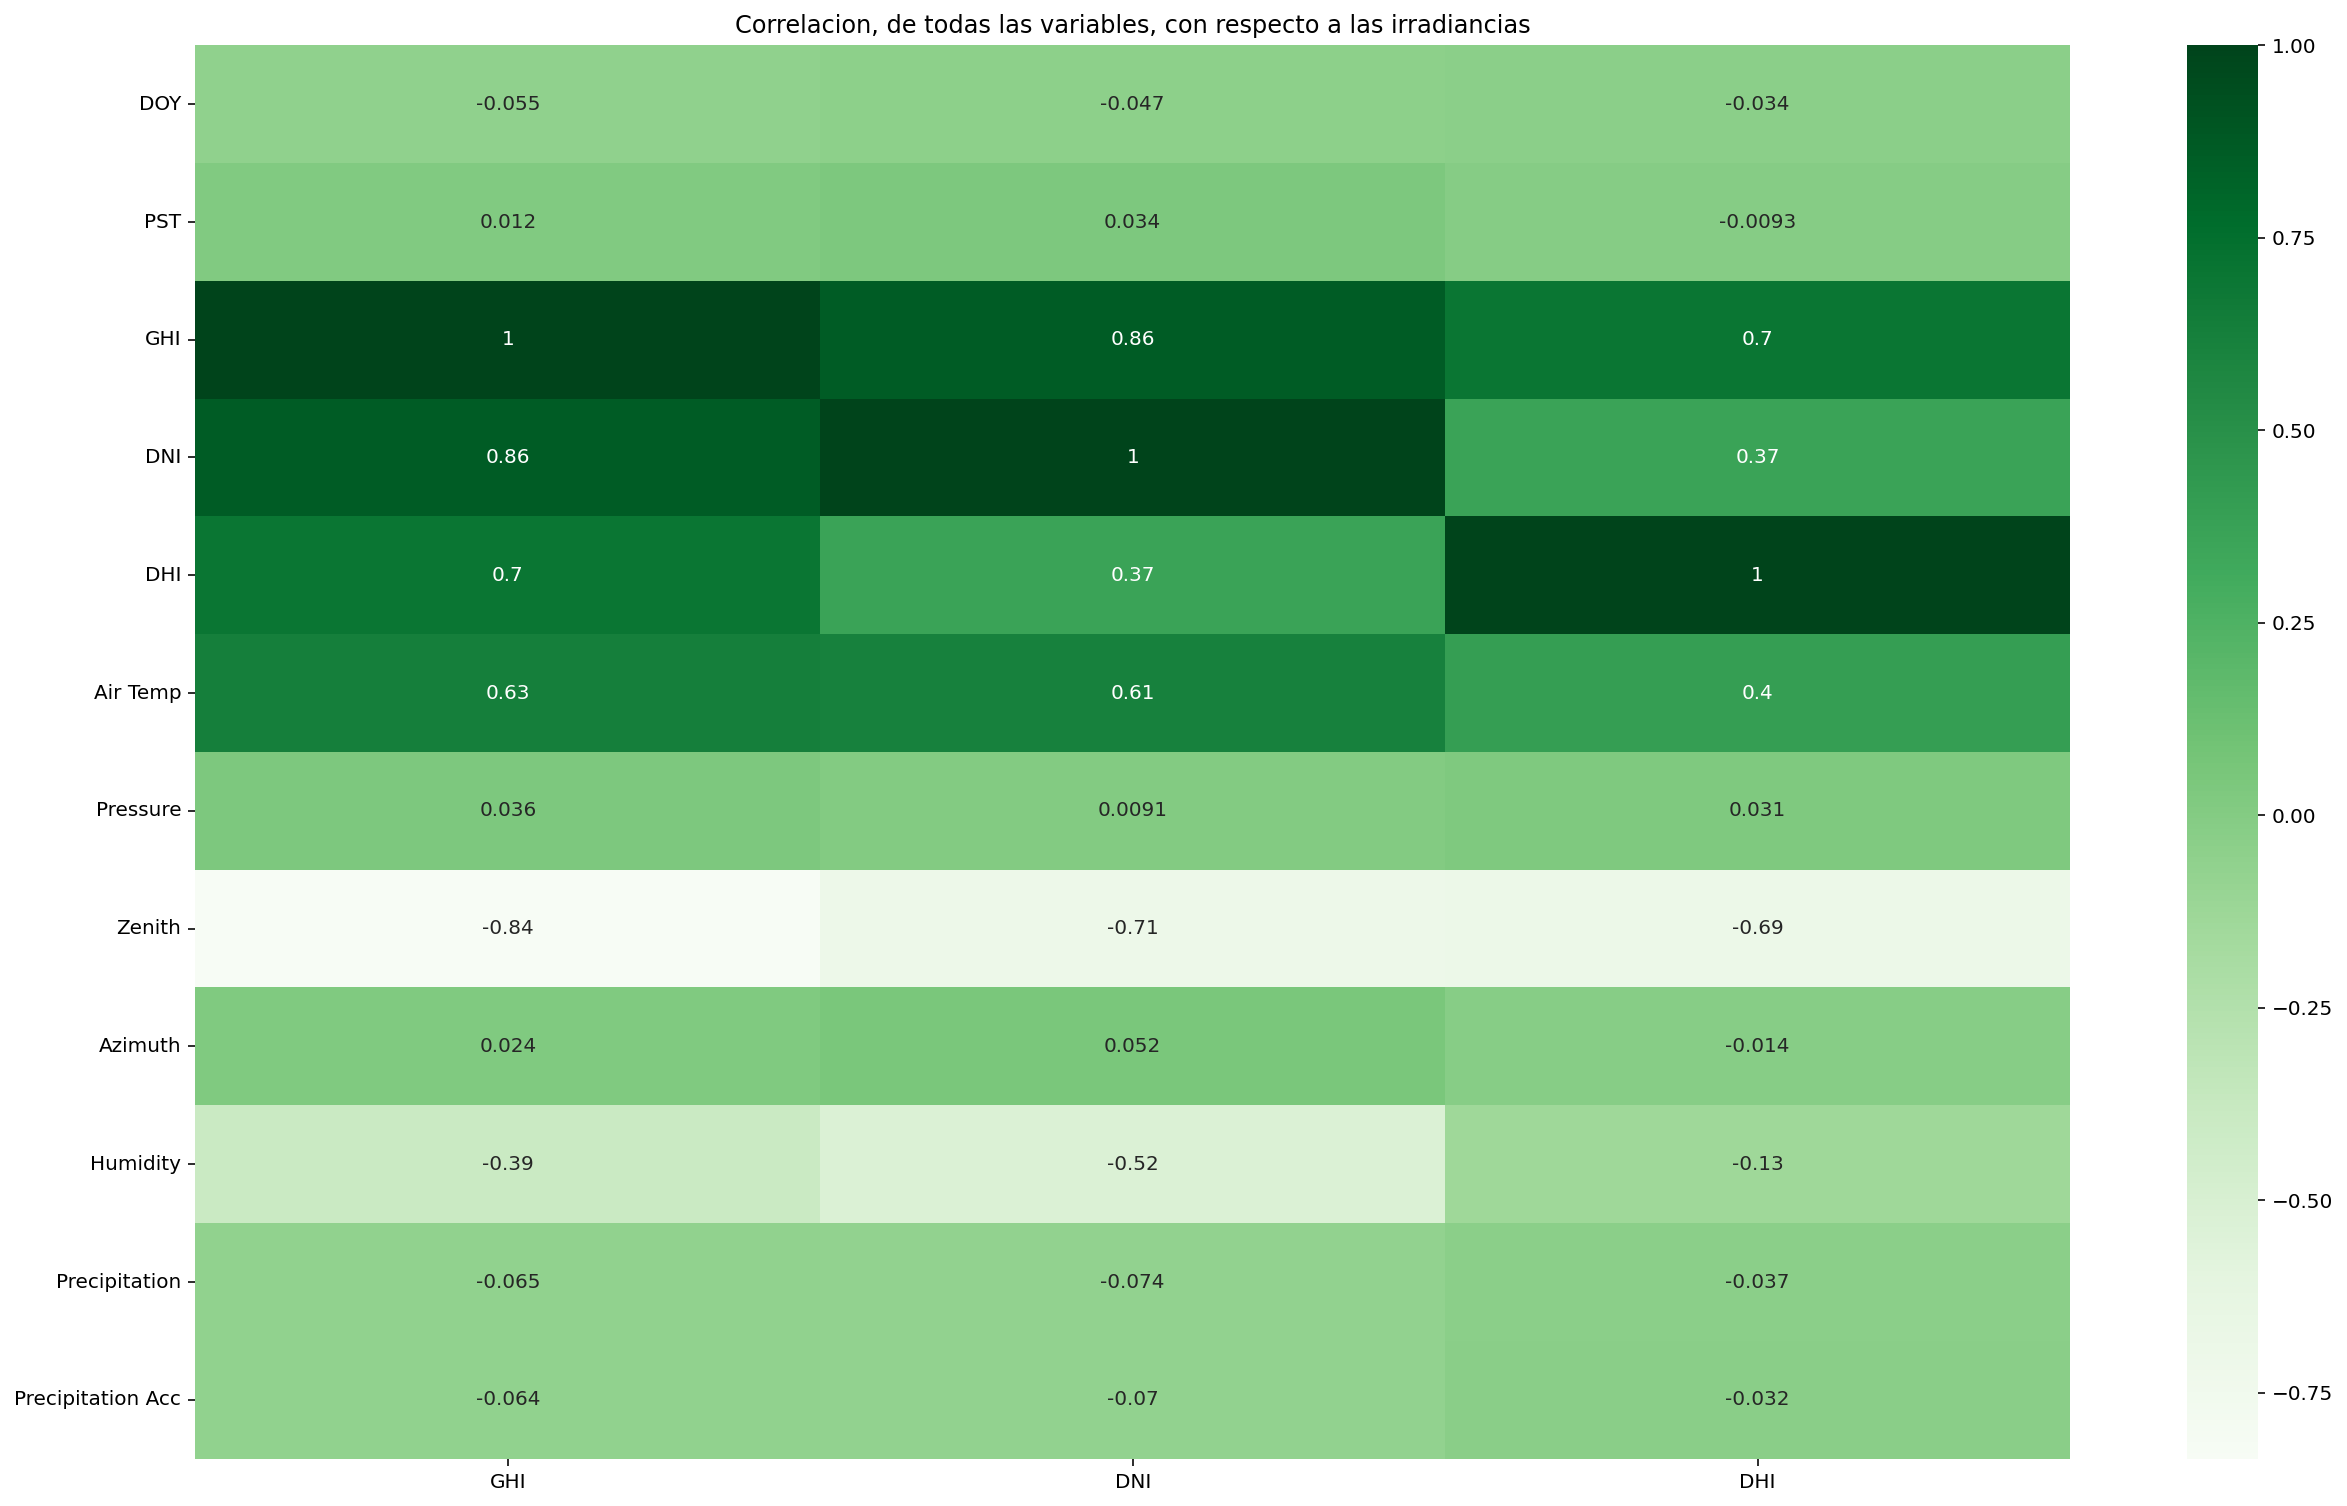

In [77]:
# Correlacion, de todas las variables, con respecto a las irradiancias
plt.figure(figsize=(21, 13))
sns.heatmap(data_re.corr()[['GHI', 'DNI', 'DHI']], cmap='Greens', annot=True)
plt.title('Correlacion, de todas las variables, con respecto a las irradiancias');

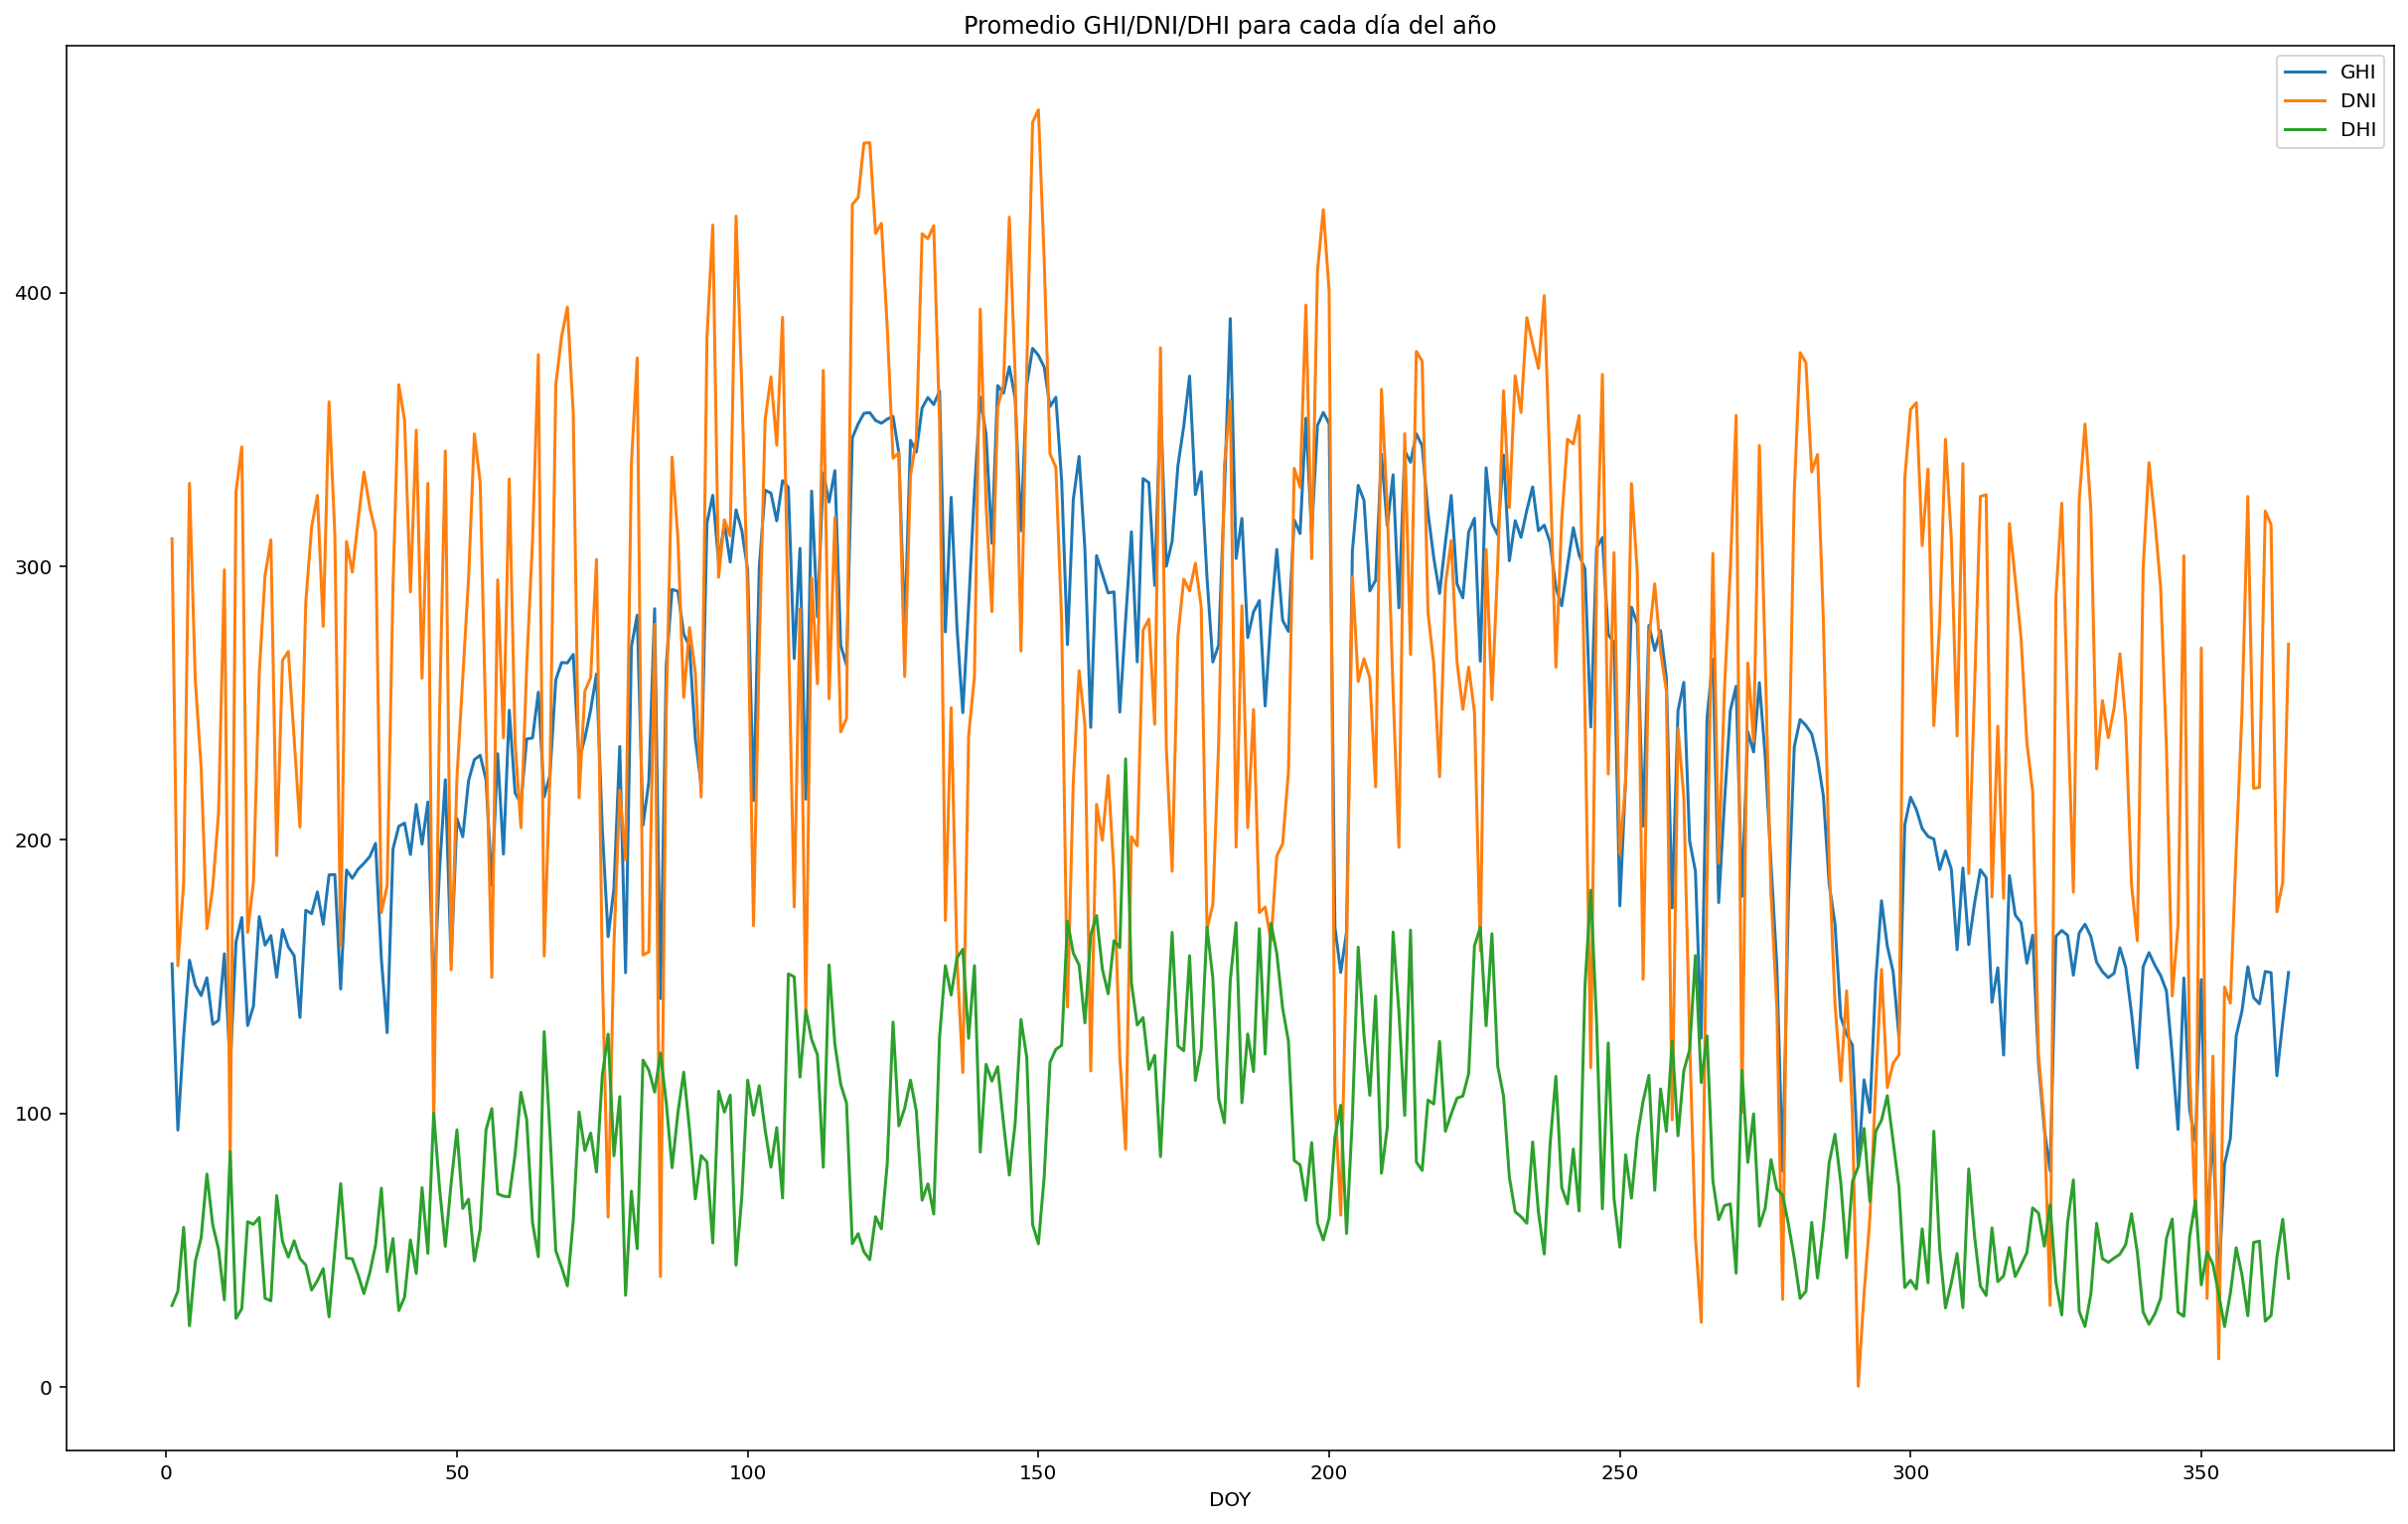

In [78]:
# Promedio de DNI/GHI/DHI para cada día al año
data_re.groupby('DOY').mean()[['GHI', 'DNI', 'DHI']].plot(figsize=(21, 13))
plt.title('Promedio GHI/DNI/DHI para cada día del año');

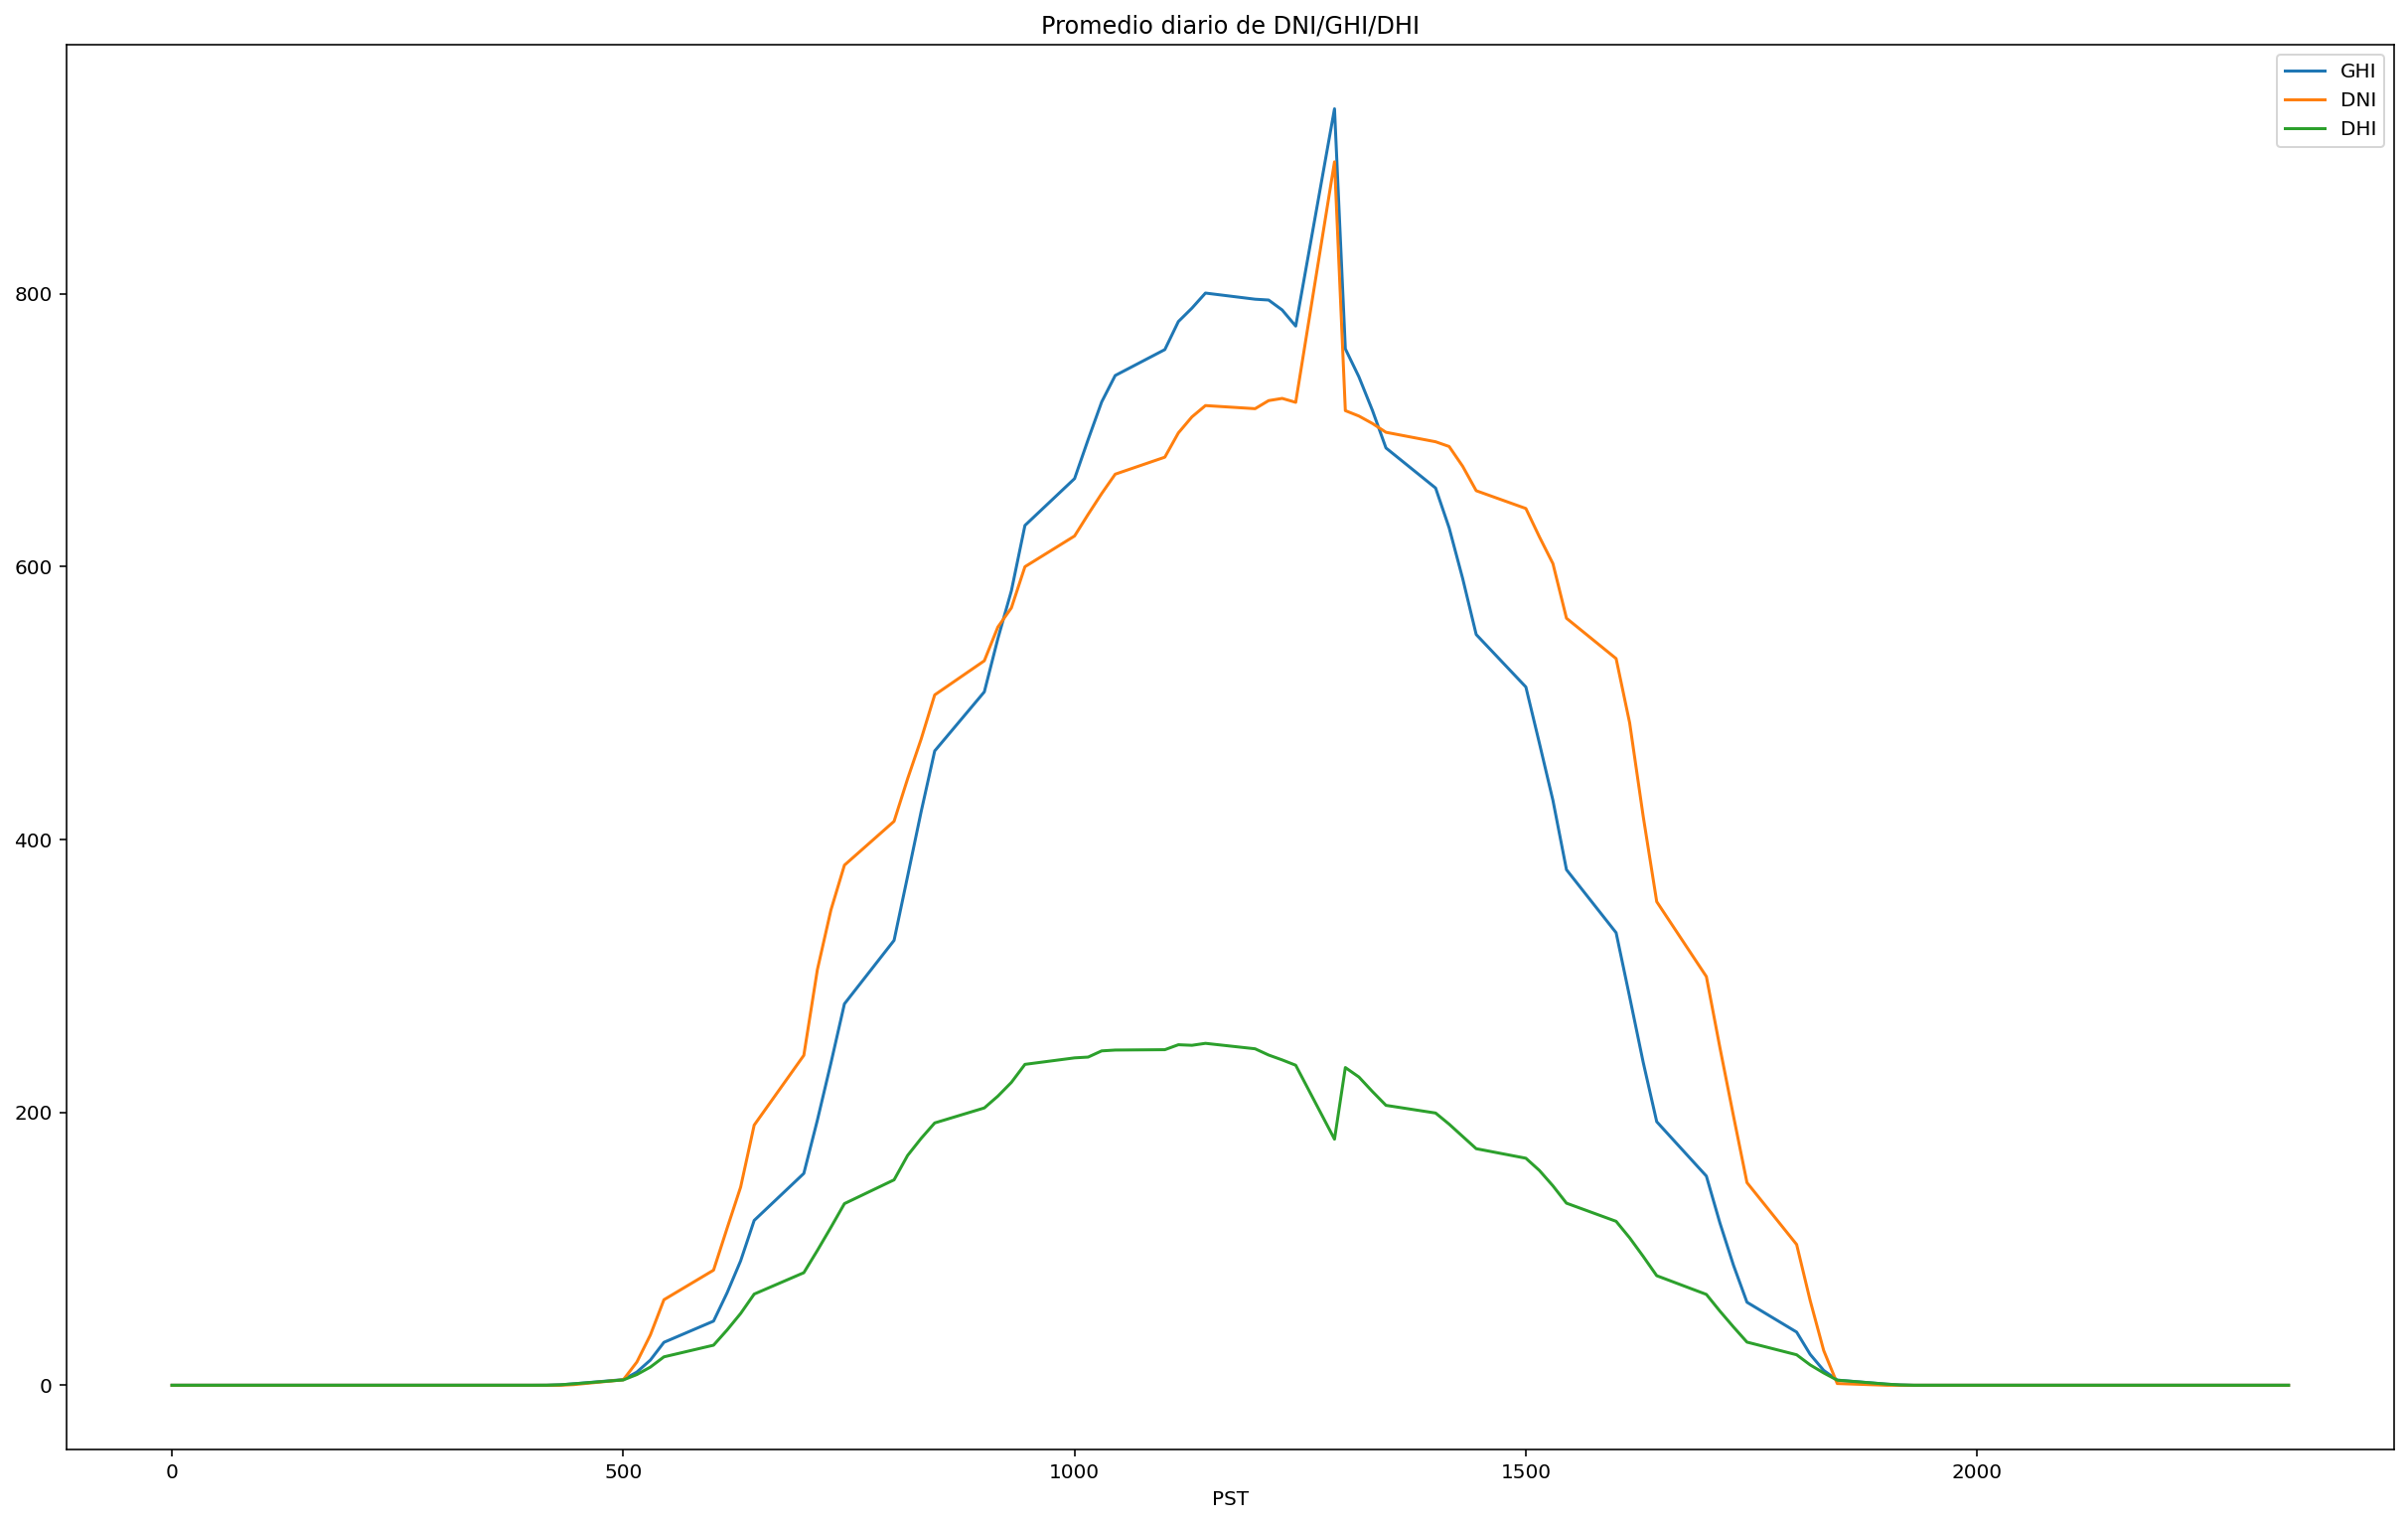

In [79]:
# Promedio diario de DNI/GHI/DHI
data_re.groupby('PST').mean()[['GHI', 'DNI', 'DHI']].plot(figsize=(21, 13))
plt.title('Promedio diario de DNI/GHI/DHI');

 # Guardar el dataset, despues de la limpieza

In [80]:
# Nombre que se le asignó y/o ruta 
ruta = 'Dataset_DNI_GHI_GNI_15min.csv' 
data_re.to_csv(ruta)